# CS 444 Final Project

In [125]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import numpy as np
import random
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import math
import sys
import time
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset, convert_solo_to_coco_api
from engine import train_one_epoch, evaluate, evaluate_solo

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

### Create Datasets

In [33]:
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

def pre_process_batch(img, mask, bbox):
        original_width = img.shape[-1]
        original_height = img.shape[-2]
        img = img / 255.0
        img = img.to(torch.float32)
        img = transforms.Resize((800, 1066), interpolation=transforms.InterpolationMode.NEAREST)(img)
        img = transforms.Pad((11,0))(img)
        mask = transforms.Resize((800, 1066), interpolation=transforms.InterpolationMode.NEAREST)(mask)
        mask = transforms.Pad((11, 0))(mask)    
       
        x_scale = 1066 / original_width
        y_scale = 800 / original_height
        bbox = torch.tensor(bbox)
        bbox[:, [0, 2]] *= x_scale  # x_min and x_max
        bbox[:, [1, 3]] *= y_scale
        bbox[:, [0, 2]] += 11  

        assert img.shape == (3, 800, 1088)
        assert bbox.shape[0] == mask.shape[0]
        return img, mask, bbox
        
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

class PennFudanDatasetSOLO(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img).float()

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        img, masks, boxes = pre_process_batch(img, masks, boxes)
        return img, target["labels"], masks, boxes, target

    def __len__(self):
        return len(self.imgs)

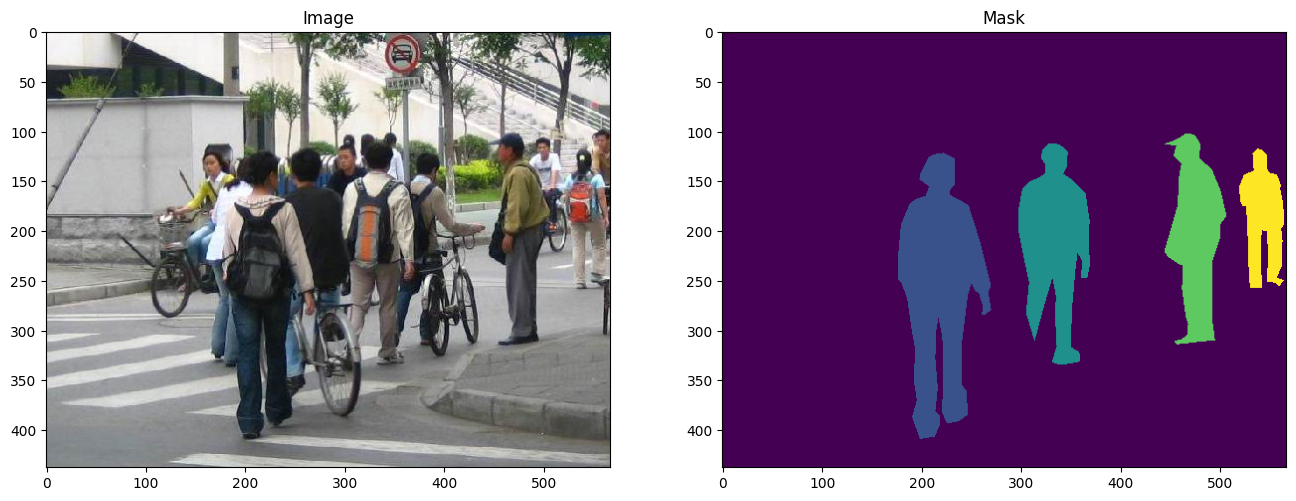

In [90]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("data/PNGImages/FudanPed00046.png")
mask = read_image("data/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [4]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

def collate_fn_solo(batch):
    imgs, labels, masks, bboxes, target = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return imgs, list(labels), list(masks), list(bboxes), list(target)

In [113]:
dataset = PennFudanDataset('data', get_transform(train=True))
dataset_test = PennFudanDataset('data', get_transform(train=False))
dataset_solo = PennFudanDatasetSOLO('data', get_transform(train=True))
dataset_test_solo = PennFudanDatasetSOLO('data', get_transform(train=False))
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
dataset_solo = torch.utils.data.Subset(dataset_solo, indices[:-50])
dataset_test_solo = torch.utils.data.Subset(dataset_test_solo, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

data_loader_solo = torch.utils.data.DataLoader(
    dataset_solo,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn_solo
)

data_loader_test_solo = torch.utils.data.DataLoader(
    dataset_test_solo,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn_solo
)

### Setup Mask R-CNN model

In [91]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


net = maskrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 2
#Change number of classes to 2 (pedestrian and background)
in_features = net.roi_heads.box_predictor.cls_score.in_features
net.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# now get the number of input features for the mask classifier
in_features_mask = net.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
net.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask,
    hidden_layer,
    num_classes
)
net = net.to(device)

In [92]:
def train(net, optimizer, num_epochs, scheduler=None):
    start_time = time.time()
    net.train()
    loss_curve = []
    for epoch in range(num_epochs):
        losses = 0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = net(images, targets)
            loss = sum(l for l in loss_dict.values())
            loss.backward()
            optimizer.step()
            losses += loss.item()
            loss_curve.append(loss.item())
        print(f"Epoch: {epoch}   Loss: {losses / len(data_loader)}")
        if scheduler is not None:
            scheduler.step()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Elapsed time: {elapsed:.2f} seconds")
    plt.plot(loss_curve, label='Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()        

In [8]:
#net.load_state_dict(torch.load("mask-rcnn.pth"))

<All keys matched successfully>

Epoch: 0   Loss: 0.4711526279648145
Epoch: 1   Loss: 0.2576516071955363
Epoch: 2   Loss: 0.226356523980697
Epoch: 3   Loss: 0.19050061292946338
Epoch: 4   Loss: 0.18282948744793734
Epoch: 5   Loss: 0.1765933858851592
Epoch: 6   Loss: 0.1729920834302902
Epoch: 7   Loss: 0.1762424943347772
Epoch: 8   Loss: 0.17341803920765717
Epoch: 9   Loss: 0.17102733639379342
Elapsed time: 260.90 seconds


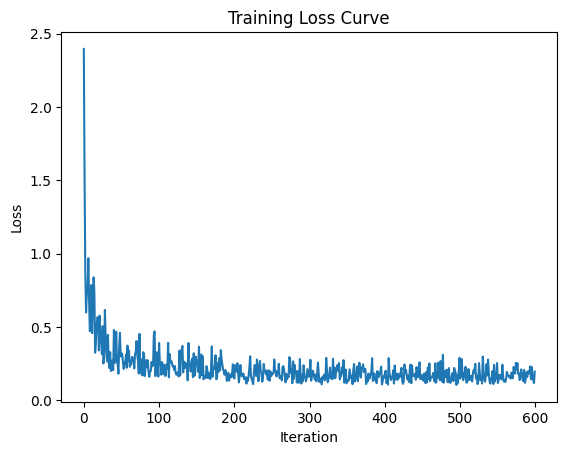

In [94]:
params = [p for p in net.parameters() if p.requires_grad]
lr = 0.005
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9,weight_decay=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
net.to(device)
train(net, optimizer, 10, lr_scheduler)
torch.save(net.state_dict(), 'models/mask-rcnn.pth')

### Visualize Results

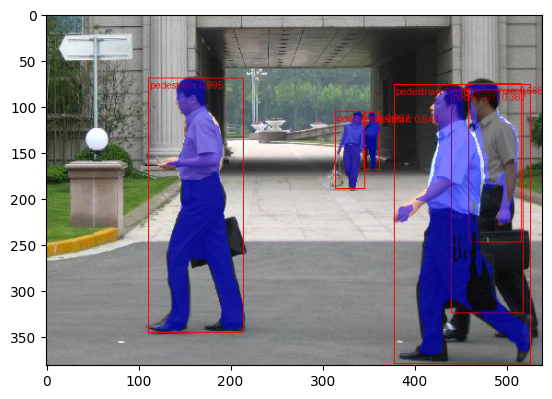

In [114]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
images, targets = next(iter(data_loader_test))
x = images[0].to(device)

net.eval()
predictions = net([x,])
pred = predictions[0]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
image = draw_bounding_boxes(x,pred["boxes"],pred_labels, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")
plt.imshow(image.permute(1,2,0))


In [95]:
evaluate(net, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:20  model_time: 0.4029 (0.4029)  evaluator_time: 0.0018 (0.0018)  time: 0.4144  data: 0.0085  max mem: 9054
Test:  [49/50]  eta: 0:00:00  model_time: 0.0707 (0.0850)  evaluator_time: 0.0041 (0.0046)  time: 0.0887  data: 0.0110  max mem: 9054
Test: Total time: 0:00:05 (0.1006 s / it)
Averaged stats: model_time: 0.0707 (0.0850)  evaluator_time: 0.0041 (0.0046)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.995
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

## 2. Solo

In [115]:
%load_ext autoreload
%autoreload 2
from solo_head import SOLOHead
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# def train_solo(model, epochs, optimizer, scheduler=None):
#     model.train()
#     for epoch in range(epochs):
#         losses = 0
#         for idx, batch in enumerate(data_loader_solo):    
#             imgs,labels,masks,bboxes = batch
#             imgs = imgs.to(device)
#             labels = [label.to(device) for label in labels]
#             masks = [mask.to(device) for mask in masks]
#             bboxes = [bbox.to(device) for bbox in bboxes]
#             batch = (imgs,labels,masks,bboxes)
            
#             loss = model.training_step(batch,idx)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             losses += loss.item()
#         print(f"Epoch: {epoch}   Loss: {losses / len(data_loader_solo)}")
#         if scheduler is not None:
#             scheduler.step()

# params = [p for p in net.parameters() if p.requires_grad]
# lr = 0.01
# optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9,weight_decay=0.005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size=3,
#     gamma=0.1
# )
# train_solo(solohead, 10, optimizer, lr_scheduler)
# torch.save(solohead.state_dict(), 'solo_model.pth')

In [147]:
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

torch.set_float32_matmul_precision('high')

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device("cuda:0" if use_cuda else "mps" if use_mps else 'cpu')
solo = SOLOHead().to(device)

logger = pl_loggers.TensorBoardLogger(save_dir = "logs")

trainer = pl.Trainer(logger= logger, max_epochs=36, precision="16-mixed",
                      check_val_every_n_epoch=1, devices=1)

trainer.fit(solo, data_loader_solo, data_loader_test_solo)

trainer.save_checkpoint("late_steps.ckpt")

Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | backbone    | BackboneWithFPN | 26.8 M | train
1 | cat_branch  | Category        | 4.1 M  | train
2 | mask_branch | Mask            | 5.1 M  | train
--------------------------------------------------------
35.9 M    Trainable params
222 K     Non-trainable params
36.1 M    Total params
144.301   Total estimated model params size (MB)
216       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_14916\2285793885.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_14916\2285793885.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bbox = torch.tensor(bbox)


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=36` reached.


### Visualize Results

In [68]:
def MatrixNMS(sorted_masks, sorted_scores, method='gauss', gauss_sigma=0.5):
    n = len(sorted_scores)
    sorted_masks = sorted_masks.reshape(n, -1)
    intersection = torch.mm(sorted_masks, sorted_masks.T)
    areas = sorted_masks.sum(dim=1).expand(n, n)
    union = areas + areas.T - intersection
    ious = (intersection / union).triu(diagonal=1)

    ious_cmax = ious.max(0)[0].expand(n, n).T
    if method == 'gauss':
        decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
    else:
        decay = (1 - ious) / (1 - ious_cmax)
    decay = decay.min(dim=0)[0]
    return sorted_scores * decay
    
def PostProcess(cate_pred_list, ins_pred_list, postprocess_cfg):
    n_levels = len(cate_pred_list)
    n_imgs = cate_pred_list[0].shape[0]
    n_channels = cate_pred_list[0].shape[-1]
    #featmap_size = seg_preds[0].size()[-2:]
    results = []
    for batch_idx in range(n_imgs):
      # 3872*3
      cat_pred_per_img = torch.cat([
          cate_pred_list[i][batch_idx].view(-1, n_channels).detach() for i in range(n_levels)
      ], dim = 0)
      # 3872 * H * W
      mask_pred_per_img = torch.cat([
          ins_pred_list[i][batch_idx].detach() for i in range(n_levels)
      ], dim = 0)

      result = PostProcessImg(cat_pred_per_img, mask_pred_per_img, postprocess_cfg)

      results.append(result)

    return results

def PostProcessImg(cat_pred_per_img, mask_pred_per_img, postprocess_cfg):
    # 3872*3 TRUE/FALSE
    indice = cat_pred_per_img > postprocess_cfg['cate_thresh']
    # Tensor, n element P > cate_thresh
    cat_pred_per_img = cat_pred_per_img[indice]

    # n (element P > cate_thresh) * 2 (class 0, 1, 2)
    indice = indice.nonzero()

    cat_labels = indice[:, 1]
    # n filtered mask_pred_per_img for P > cate_thresh
    mask_pred_per_img = mask_pred_per_img[indice[:, 0]]

    binary_mask = mask_pred_per_img > postprocess_cfg['mask_thresh']

    num_p = binary_mask.sum((1, 2)).float()

    maskness = (mask_pred_per_img * binary_mask).sum((1, 2)) / num_p

    cat_pred_per_img *= maskness

    # NMS process
    sorted_index = torch.argsort(cat_pred_per_img, descending=True)
    sorted_index = sorted_index if len(sorted_index) <= postprocess_cfg['pre_NMS_num'] else sorted_index[:postprocess_cfg['pre_NMS_num']]

    sorted_masks = binary_mask[sorted_index].float()
    sorted_cat_pred = cat_pred_per_img[sorted_index]
    sorted_mask_preds = mask_pred_per_img[sorted_index]
    cat_labels = cat_labels[sorted_index]

    cat_pred_per_img = MatrixNMS(sorted_masks, sorted_cat_pred)

    # Keep top k
    sorted_index = torch.argsort(cat_pred_per_img, descending=True)
    sorted_index = sorted_index[:postprocess_cfg['keep_instance']]
    sorted_mask_preds = sorted_mask_preds[sorted_index]
    cat_pred_per_img = cat_pred_per_img[sorted_index]
    cat_labels = cat_labels[sorted_index]
    filter_idx_again = cat_pred_per_img > postprocess_cfg['cate_thresh']
    cat_pred_per_img = cat_pred_per_img[filter_idx_again]
    sorted_mask_preds = sorted_mask_preds[filter_idx_again]
    cat_labels = cat_labels[filter_idx_again]

    binary_masks = sorted_mask_preds > postprocess_cfg['mask_thresh']

    return binary_masks, cat_pred_per_img, cat_labels


import os
def PlotInfer(images, results, output_filename):
    batch_len = len(results)
    figure, axes_grid = plt.subplots(1, batch_len, figsize=(8 * batch_len, 8))
    mean_values = [0.485, 0.456, 0.406]
    std_values = [0.229, 0.224, 0.225]

    # Define color mapping for different labels
    label_colors = {
        0: [1, 0, 0, 0.5],   # Red for label 0
        1: [0, 1, 0, 0.5],   # Green for label 1
        2: [0, 0, 1, 0.5]    # Blue for label 2
    }

    images_np = images.cpu().numpy()
    images_np = np.moveaxis(images_np, 1, -1)
    #images_np = (images_np * std_values) + mean_values
    images_np = np.clip(images_np, 0, 1)
    

    for idx in range(batch_len):
        single_image = images_np[idx]
        if batch_len == 1:
            current_axis = axes_grid
        else:
            current_axis = axes_grid[idx]
        result_masks = results[idx][0].cpu()
        result_labels = results[idx][2]
        result_scores = results[idx][1]
        current_axis.imshow(single_image)

        for mask_idx, single_mask in enumerate(result_masks):
            # if result_scores[mask_idx] < 0.2:
            #     continue

            # Create an overlay for the mask using the color mapped from the label
            overlay_img = np.zeros((single_image.shape[0], single_image.shape[1], 4))
            current_label = result_labels[mask_idx].item()

            # Resize the mask
            scaled_mask = Func.interpolate(single_mask[None, None, :, :].float(), size=(800, 1088), mode='nearest').squeeze()

            # Get the color for the current label or use a default (e.g., red) if the label is unknown
            color = label_colors[current_label]
            overlay_img[scaled_mask != 0] = color

            current_axis.imshow(overlay_img)

    plt.tight_layout()
    output_directory = os.path.join('solo_output', output_filename)
    plt.savefig(output_directory, dpi=80, bbox_inches='tight')



C:\Users\Jonathan\AppData\Local\Temp\ipykernel_34656\3954977201.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bbox = torch.tensor(bbox)


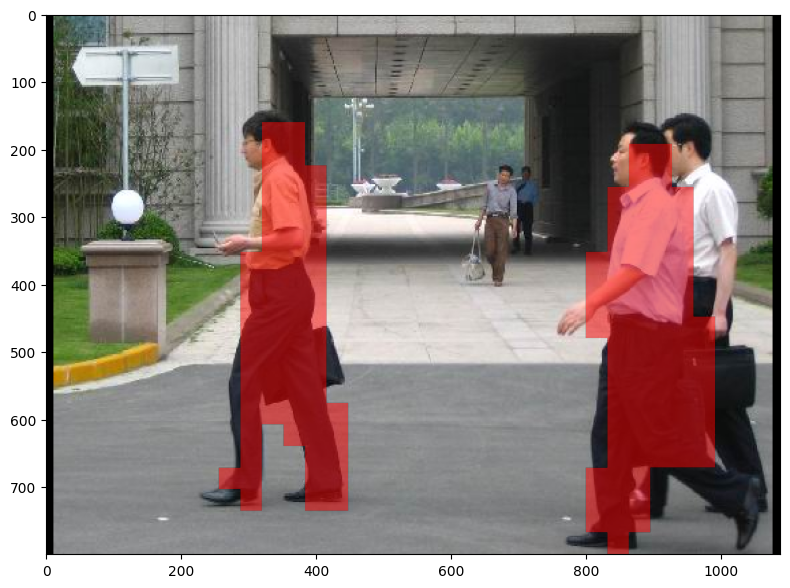

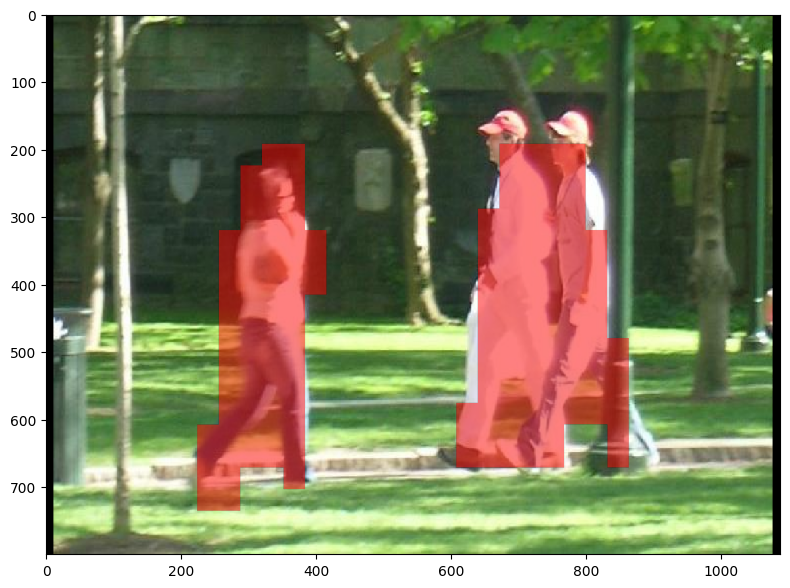

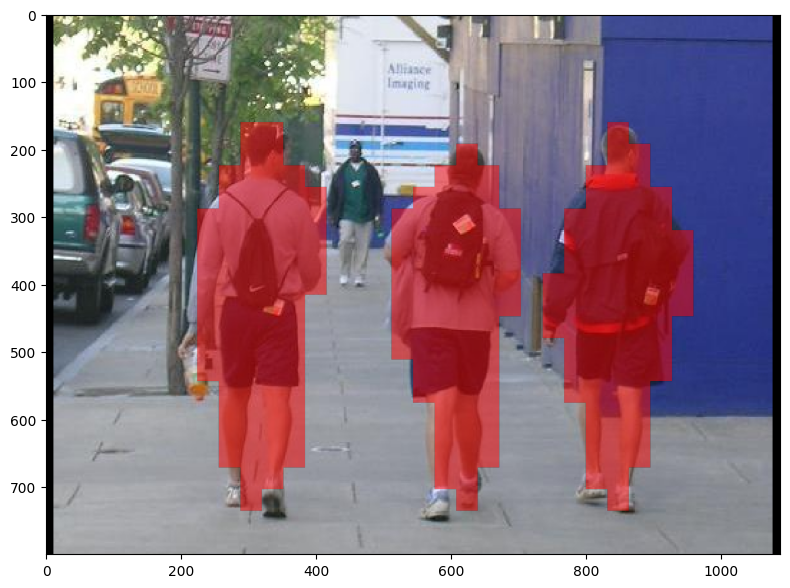

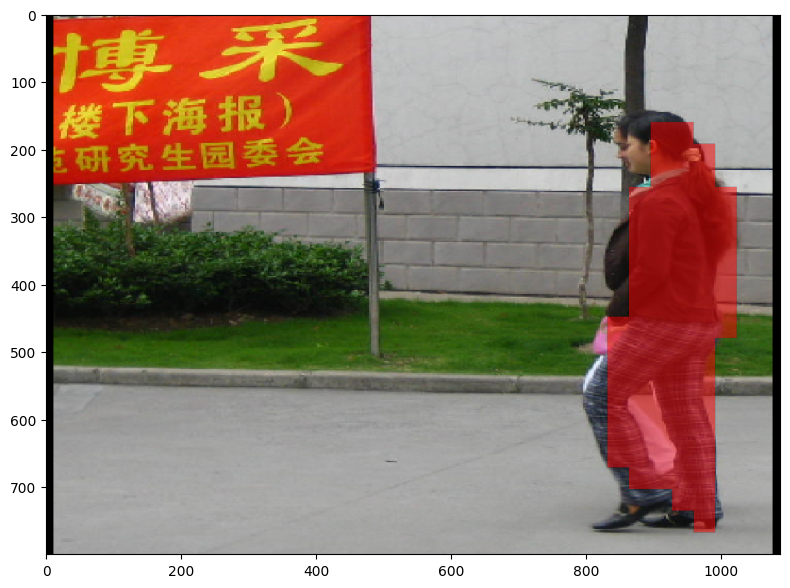

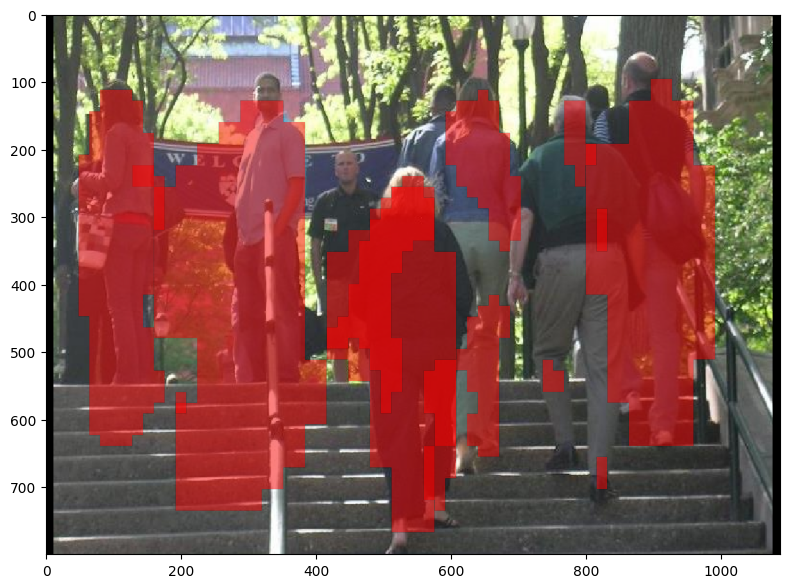

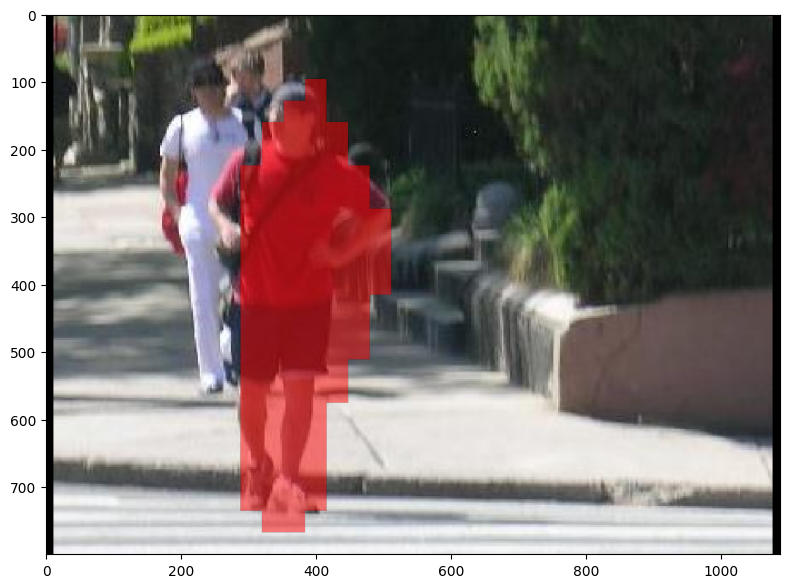

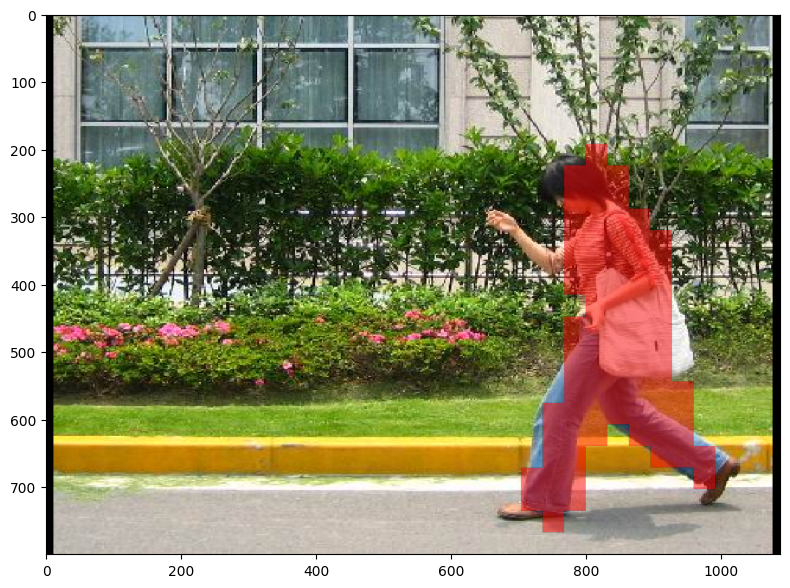

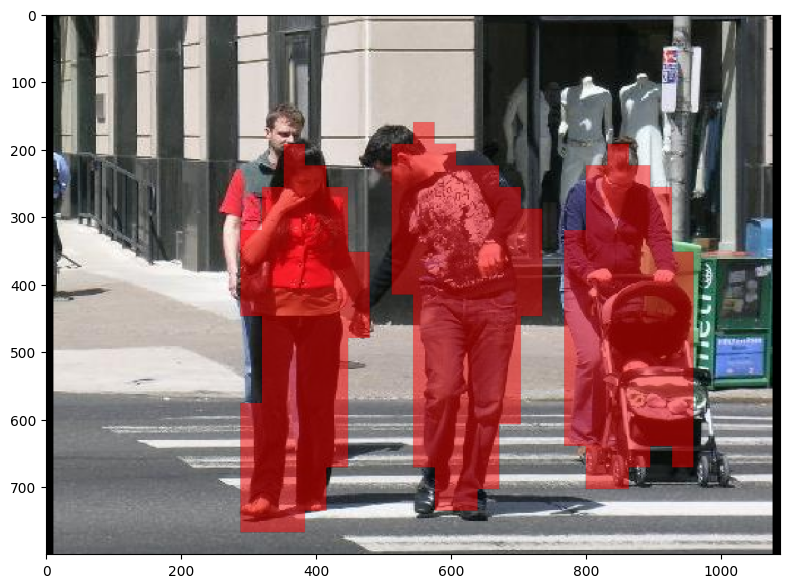

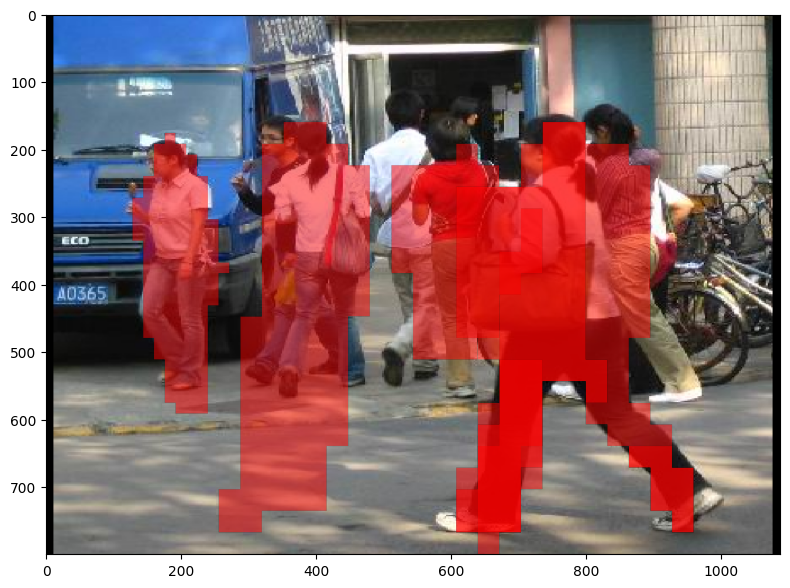

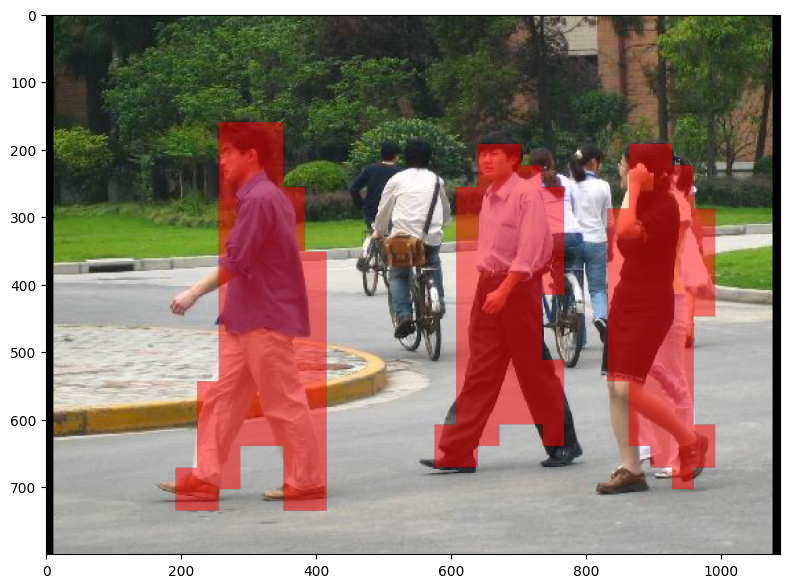

In [117]:
import torch.nn.functional as Func
solo = SOLOHead.load_from_checkpoint("paper_hyperparameters.ckpt")
solo = solo.to(device)
for it, data in enumerate(data_loader_test_solo, 0):
  if it < 10:
    one_batch = data
    imgs, labels, masks, bboxes, target = one_batch
    del one_batch, labels, masks, bboxes
    imgs = imgs.to(device)
    cate_pred_list, ins_pred_list = solo(imgs, True)
    result = PostProcess(cate_pred_list, ins_pred_list, solo.postprocess_cfg)
    PlotInfer(imgs, result, f"test_{it}.png")
    del result

In [126]:
solo = solo.to(device)
evaluate_solo(solo, data_loader_test_solo, device=device)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_34656\3954977201.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bbox = torch.tensor(bbox)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:08  model_time: 0.1469 (0.1469)  evaluator_time: 0.0009 (0.0009)  time: 0.1758  data: 0.0242  max mem: 11246
Test:  [49/50]  eta: 0:00:00  model_time: 0.1036 (0.1147)  evaluator_time: 0.0006 (0.0007)  time: 0.1293  data: 0.0231  max mem: 11246
Test: Total time: 0:00:07 (0.1415 s / it)
Averaged stats: model_time: 0.1036 (0.1147)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ I